c:\Users\dungh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\dungh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


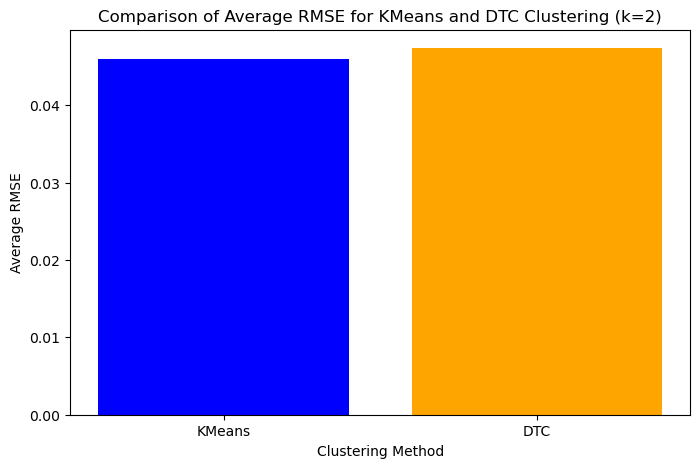

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

# Load and preprocess data
data = pd.read_csv(r"file_transposed_updated1 (2).csv")
revenue_columns = ['Tổng', 'Thương nghiệp', 'Khách sạn nhà hàng', 'Du lịch', 'Dịch vụ']

# Scale data
scaler = MinMaxScaler()
data[revenue_columns] = scaler.fit_transform(data[revenue_columns])

# Create LSTM dataset with look-back
look_back = 12
def create_lstm_dataset(data, look_back=12):
    X = []
    y = []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)][revenue_columns].values)
        y.append(data.iloc[i + look_back][revenue_columns[0]])  # Use 'Tổng' as the target
    return np.array(X), np.array(y)

X, y = create_lstm_dataset(data, look_back=look_back)

# Define the Autoencoder model
timesteps = X.shape[1]
features = X.shape[2]

input_layer = Input(shape=(timesteps, features))
encoded = LSTM(256, activation='relu', return_sequences=True)(input_layer)
encoded = LSTM(128, activation='relu', return_sequences=True)(encoded)
latent_space = LSTM(64, activation='relu', return_sequences=False)(encoded)

decoded = RepeatVector(timesteps)(latent_space)
decoded = LSTM(128, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(256, activation='relu', return_sequences=True)(decoded)
output_layer = TimeDistributed(Dense(features))(decoded)

# Define the Clustering Layer for DTC
class ClusteringLayer(tf.keras.layers.Layer):
    def __init__(self, num_clusters, **kwargs):
        super(ClusteringLayer, self).__init__(**kwargs)
        self.num_clusters = num_clusters

    def build(self, input_shape):
        self.clusters = self.add_weight(shape=(self.num_clusters, input_shape[-1]),
                                        initializer='he_normal',
                                        trainable=True)

    def call(self, inputs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2)))
        q = q ** ((1.0 + 1.0) / 2.0)
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

# Set k = 2 for both KMeans and DTC
k = 2

# KMeans clustering
kmeans = KMeans(n_clusters=k, random_state=0)
cluster_labels_kmeans = kmeans.fit_predict(X[:, -1, :])  # Use the last timestep for clustering

# Calculate RMSE for each cluster in KMeans
rmse_per_cluster_kmeans = []
for cluster_id in range(k):
    X_cluster = X[cluster_labels_kmeans == cluster_id]
    y_cluster = y[cluster_labels_kmeans == cluster_id]
    if len(X_cluster) > 1:
        X_rf = X_cluster[:, -1, :]
        X_train, X_test, y_train, y_test = train_test_split(X_rf, y_cluster, test_size=0.2, random_state=0)
        model = RandomForestRegressor(n_estimators=100, random_state=0)
        model.fit(X_train, y_train)
        y_pred_rf = model.predict(X_test)
        rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
        rmse_per_cluster_kmeans.append(rmse_rf)
rmse_kmeans_avg = np.mean(rmse_per_cluster_kmeans)

# DTC clustering with ClusteringLayer
clustering_layer = ClusteringLayer(k, name='clustering')(latent_space)
autoencoder = Model(inputs=input_layer, outputs=[output_layer, clustering_layer])
autoencoder.compile(optimizer='adam', loss=['mse', 'kld'], loss_weights=[1.0, 0.5])
autoencoder.fit(X, [X, np.zeros((X.shape[0], k))], epochs=50, batch_size=16, verbose=0)
encoder = Model(inputs=input_layer, outputs=latent_space)
latent_space_output = encoder.predict(X)
q_values = autoencoder.predict(X)[1]
cluster_labels_dtc = np.argmax(q_values, axis=1)

# Calculate RMSE for each cluster in DTC
rmse_per_cluster_dtc = []
for cluster_id in range(k):
    X_cluster = X[cluster_labels_dtc == cluster_id]
    y_cluster = y[cluster_labels_dtc == cluster_id]
    if len(X_cluster) > 1:
        X_rf = X_cluster[:, -1, :]
        X_train, X_test, y_train, y_test = train_test_split(X_rf, y_cluster, test_size=0.2, random_state=0)
        model = RandomForestRegressor(n_estimators=100, random_state=0)
        model.fit(X_train, y_train)
        y_pred_rf = model.predict(X_test)
        rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
        rmse_per_cluster_dtc.append(rmse_rf)
rmse_dtc_avg = np.mean(rmse_per_cluster_dtc)

# Plotting results for k = 2
plt.figure(figsize=(8, 5))
methods = ['KMeans', 'DTC']
rmse_values = [rmse_kmeans_avg, rmse_dtc_avg]
plt.bar(methods, rmse_values, color=['blue', 'orange'])
plt.xlabel('Clustering Method')
plt.ylabel('Average RMSE')
plt.title('Comparison of Average RMSE for KMeans and DTC Clustering (k=2)')
plt.show()


c:\Users\dungh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\dungh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\dungh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\dungh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

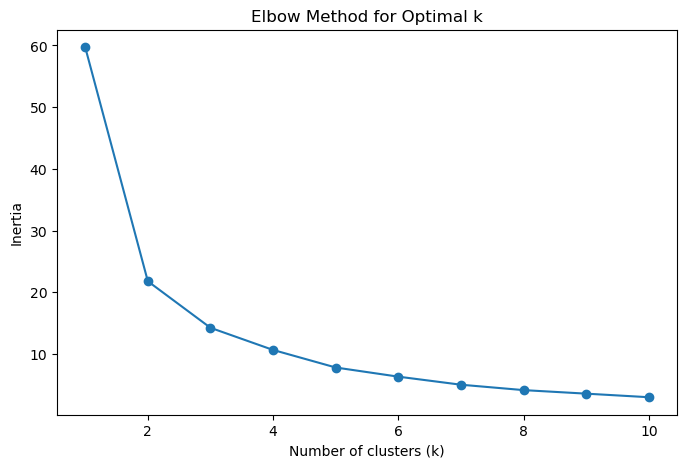

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load and preprocess data
data = pd.read_csv(r"file_transposed_updated1 (2).csv")
revenue_columns = ['Tổng', 'Thương nghiệp', 'Khách sạn nhà hàng', 'Du lịch', 'Dịch vụ']

# Scale data
scaler = MinMaxScaler()
data[revenue_columns] = scaler.fit_transform(data[revenue_columns])

# Prepare data for clustering
X = data[revenue_columns].values  # Chọn các cột cần thiết cho phân cụm

# Determine the optimal number of clusters using the Elbow Method
inertia = []
k_range = range(1, 11)  # Kiểm tra k từ 1 đến 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.show()


c:\Users\dungh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\dungh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step


c:\Users\dungh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\dungh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 323ms/step


c:\Users\dungh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\dungh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 385ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step


c:\Users\dungh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\dungh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 276ms/step


c:\Users\dungh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\dungh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step


c:\Users\dungh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\dungh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 286ms/step


c:\Users\dungh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\dungh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


c:\Users\dungh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\dungh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


c:\Users\dungh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\dungh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 563ms/step


c:\Users\dungh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\dungh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step


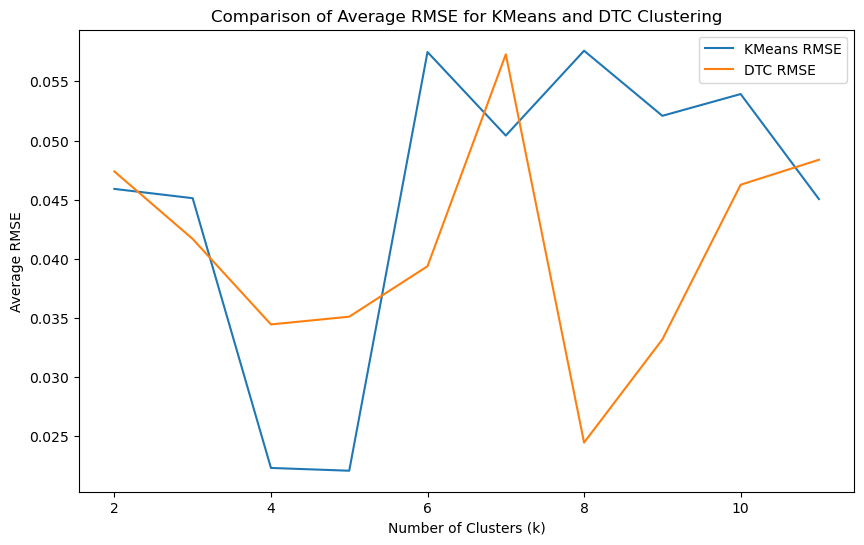

In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

# Load and preprocess data
data = pd.read_csv('file_transposed_updated1 (2).csv')
revenue_columns = ['Tổng', 'Thương nghiệp', 'Khách sạn nhà hàng', 'Du lịch', 'Dịch vụ']

# Scale data
scaler = MinMaxScaler()
data[revenue_columns] = scaler.fit_transform(data[revenue_columns])

# Create LSTM dataset with look-back
look_back = 12
def create_lstm_dataset(data, look_back=12):
    X = []
    y = []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)][revenue_columns].values)
        y.append(data.iloc[i + look_back][revenue_columns[0]])  # Use 'Tổng' as the target
    return np.array(X), np.array(y)

X, y = create_lstm_dataset(data, look_back=look_back)

# Define the Autoencoder model
timesteps = X.shape[1]
features = X.shape[2]

input_layer = Input(shape=(timesteps, features))
encoded = LSTM(256, activation='relu', return_sequences=True)(input_layer)
encoded = LSTM(128, activation='relu', return_sequences=True)(encoded)
latent_space = LSTM(64, activation='relu', return_sequences=False)(encoded)

decoded = RepeatVector(timesteps)(latent_space)
decoded = LSTM(128, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(256, activation='relu', return_sequences=True)(decoded)
output_layer = TimeDistributed(Dense(features))(decoded)

# Define the Clustering Layer for DTC
class ClusteringLayer(tf.keras.layers.Layer):
    def __init__(self, num_clusters, **kwargs):
        super(ClusteringLayer, self).__init__(**kwargs)
        self.num_clusters = num_clusters

    def build(self, input_shape):
        self.clusters = self.add_weight(shape=(self.num_clusters, input_shape[-1]),
                                        initializer='he_normal',
                                        trainable=True)

    def call(self, inputs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2)))
        q = q ** ((1.0 + 1.0) / 2.0)
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

# Store RMSE results for each method and k
rmse_kmeans = []
rmse_dtc = []

# Loop through k values from 2 to 11
for k in range(2, 12):
    # KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=0)
    cluster_labels_kmeans = kmeans.fit_predict(X[:, -1, :])  # Use the last timestep for clustering

    # Calculate RMSE for each cluster in KMeans
    rmse_per_cluster_kmeans = []
    for cluster_id in range(k):
        X_cluster = X[cluster_labels_kmeans == cluster_id]
        y_cluster = y[cluster_labels_kmeans == cluster_id]
        if len(X_cluster) > 1:
            X_rf = X_cluster[:, -1, :]
            X_train, X_test, y_train, y_test = train_test_split(X_rf, y_cluster, test_size=0.2, random_state=0)
            model = RandomForestRegressor(n_estimators=100, random_state=0)
            model.fit(X_train, y_train)
            y_pred_rf = model.predict(X_test)
            rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
            rmse_per_cluster_kmeans.append(rmse_rf)
    rmse_kmeans.append(np.mean(rmse_per_cluster_kmeans))

    # DTC clustering with ClusteringLayer
    clustering_layer = ClusteringLayer(k, name='clustering')(latent_space)
    autoencoder = Model(inputs=input_layer, outputs=[output_layer, clustering_layer])
    autoencoder.compile(optimizer='adam', loss=['mse', 'kld'], loss_weights=[1.0, 0.5])
    autoencoder.fit(X, [X, np.zeros((X.shape[0], k))], epochs=50, batch_size=16, verbose=0)
    encoder = Model(inputs=input_layer, outputs=latent_space)
    latent_space_output = encoder.predict(X)
    q_values = autoencoder.predict(X)[1]
    cluster_labels_dtc = np.argmax(q_values, axis=1)

    # Calculate RMSE for each cluster in DTC
    rmse_per_cluster_dtc = []
    for cluster_id in range(k):
        X_cluster = X[cluster_labels_dtc == cluster_id]
        y_cluster = y[cluster_labels_dtc == cluster_id]
        if len(X_cluster) > 1:
            X_rf = X_cluster[:, -1, :]
            X_train, X_test, y_train, y_test = train_test_split(X_rf, y_cluster, test_size=0.2, random_state=0)
            model = RandomForestRegressor(n_estimators=100, random_state=0)
            model.fit(X_train, y_train)
            y_pred_rf = model.predict(X_test)
            rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
            rmse_per_cluster_dtc.append(rmse_rf)
    rmse_dtc.append(np.mean(rmse_per_cluster_dtc))

# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(range(2, 12), rmse_kmeans, label='KMeans RMSE')
plt.plot(range(2, 12), rmse_dtc, label='DTC RMSE')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average RMSE')
plt.title('Comparison of Average RMSE for KMeans and DTC Clustering')
plt.legend()
plt.show()


In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K

# Load and preprocess data
data = pd.read_csv(r"file_transposed_updated1 (2).csv")
revenue_columns = ['Tổng', 'Thương nghiệp', 'Khách sạn nhà hàng', 'Du lịch', 'Dịch vụ']

# Scale data
scaler = MinMaxScaler()
data[revenue_columns] = scaler.fit_transform(data[revenue_columns])

# Create LSTM dataset with look-back
look_back = 12
def create_lstm_dataset(data, look_back=12):
    X = []
    y = []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)][revenue_columns].values)
        y.append(data.iloc[i + look_back][revenue_columns].values)  # Use all columns as the target
    return np.array(X), np.array(y)

X, y = create_lstm_dataset(data, look_back=look_back)

# Define the Autoencoder model
timesteps = X.shape[1]
features = X.shape[2]
num_clusters = 3  # Number of clusters

input_layer = Input(shape=(timesteps, features))
encoded = LSTM(256, activation='relu', return_sequences=True)(input_layer)
encoded = LSTM(128, activation='relu', return_sequences=True)(encoded)
latent_space = LSTM(64, activation='relu', return_sequences=False)(encoded)

decoded = RepeatVector(timesteps)(latent_space)
decoded = LSTM(128, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(256, activation='relu', return_sequences=True)(decoded)
output_layer = TimeDistributed(Dense(features))(decoded)

# Define the Clustering Layer for DTC
class ClusteringLayer(tf.keras.layers.Layer):
    def __init__(self, num_clusters, **kwargs):
        super(ClusteringLayer, self).__init__(**kwargs)
        self.num_clusters = num_clusters

    def build(self, input_shape):
        self.clusters = self.add_weight(shape=(self.num_clusters, input_shape[-1]),
                                        initializer='he_normal',
                                        trainable=True)

    def call(self, inputs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2)))
        q = q ** ((1.0 + 1.0) / 2.0)
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

# Instantiate and connect clustering layer
clustering_layer = ClusteringLayer(num_clusters, name='clustering')(latent_space)

# Compile the Autoencoder model with clustering
autoencoder = Model(inputs=input_layer, outputs=[output_layer, clustering_layer])
autoencoder.compile(optimizer='adam', loss=['mse', 'kld'], loss_weights=[1.0, 0.5])

# Pre-train the Autoencoder without clustering
autoencoder_pretrain = Model(inputs=input_layer, outputs=output_layer)
autoencoder_pretrain.compile(optimizer='adam', loss='mse')
autoencoder_pretrain.fit(X, X, epochs=50, batch_size=16, verbose=1)

# Fine-tune the model with clustering
autoencoder.fit(X, [X, np.zeros((X.shape[0], num_clusters))], epochs=100, batch_size=16, verbose=1)

# Extract latent space for clustering
encoder = Model(inputs=input_layer, outputs=latent_space)
latent_space_output = encoder.predict(X)

# Get clustering output from the model
q_values = autoencoder.predict(X)[1]  # Use the second output for clustering
cluster_labels = np.argmax(q_values, axis=1)

# Prepare data for prediction
X_clustered = np.hstack([X[:, -1, :], cluster_labels.reshape(-1, 1)])  # Add cluster labels to the last timestep
X_clustered = pd.DataFrame(X_clustered, columns=revenue_columns + ['Cluster'])

# Prepare features (X) and target (y) for LSTM prediction
X_lstm = X_clustered.drop(columns=['Cluster']).values  # Features
y_lstm = y  # Target

# Ensure the number of samples is divisible by look_back
num_samples = X_lstm.shape[0]
if num_samples % look_back != 0:
    X_lstm = X_lstm[:num_samples - (num_samples % look_back)]  # Truncate to make it divisible

# Reshape X for LSTM
X_lstm = X_lstm.reshape((-1, look_back, features))  # Reshape to (num_samples // look_back, look_back, features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm[:X_lstm.shape[0]], test_size=0.2, random_state=0)

# Define the Random Forest model for prediction
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X_train.reshape(X_train.shape[0], -1), y_train)  # Flatten for Random Forest

# Make predictions
y_pred_rf = model.predict(X_test.reshape(X_test.shape[0], -1))  # Flatten for predictions

# Calculate RMSE for each predicted column
for i, col in enumerate(revenue_columns):
    rmse = np.sqrt(mean_squared_error(y_test[:, i], y_pred_rf[:, i]))
    print(f"RMSE for {col}:", rmse)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.2520
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1588
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1176
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0766
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0702
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0399
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0302
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0252
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0185
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0144
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0150
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0142
Epoch 13/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0125
Epoch 14/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0108
Epoch 15/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0103
Epoc

In [7]:
# Tính RMSE trên tập huấn luyện
y_train_pred = model.predict(X_train.reshape(X_train.shape[0], -1))  # Dự đoán trên tập huấn luyện
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print("RMSE for Random Forest on Training Set:", rmse_train)

# Tính RMSE trên tập kiểm tra
y_test_pred = model.predict(X_test.reshape(X_test.shape[0], -1))  # Dự đoán trên tập kiểm tra
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("RMSE for Random Forest on Testing Set:", rmse_test)


RMSE for Random Forest on Training Set: 0.00513677329057522
RMSE for Random Forest on Testing Set: 0.00864388226845416


So với việc sử dụng các phương pháp phân cụm truyền thống như Kmean, chỉ số RMSE của mô hình đã được cải thiện

In [19]:
import calendar
import numpy as np

# Danh sách tên các tháng
months = [calendar.month_name[i] for i in range(1, 9)]

# Sử dụng scaler để chuẩn hóa dữ liệu và tạo dữ liệu cho năm 2025
n_months_predict = 8  # Số tháng cần dự đoán cho năm 2025
predictions_2025 = []

# Lấy các bước thời gian cuối cùng từ dữ liệu gốc để dự đoán
last_sequence = X_lstm[-1]  # Shape: (look_back, features), e.g., (12, 5)

# Dự đoán từng tháng của năm 2025
for _ in range(n_months_predict):
    # Use only the last timestep for prediction
    last_timestep = last_sequence[-1]  # Shape: (5,)
    pred = model.predict(last_timestep.reshape(1, -1))  # Shape: (1, 1)
    
    # Lưu dự đoán (chỉ lấy 'Tổng' và đưa về giá trị gốc)
    pred_transform = np.array([[pred[0]] + [0] * (features - 1)])  # Shape: (1, 5)
    revenue_total = scaler.inverse_transform(pred_transform)[0, 0]
    predictions_2025.append(revenue_total)
    
    # Cập nhật last_sequence để tiếp tục dự đoán tháng tiếp theo
    new_sequence = np.roll(last_sequence, -1, axis=0)  # Dịch các bước thời gian
    new_sequence[-1, 0] = pred[0]  # Thêm dự đoán mới cho 'Tổng'
    last_sequence = new_sequence  # Cập nhật chuỗi cuối cùng

# In ra các dự đoán cho năm 2025 với tên tháng
print("Dự đoán doanh thu (Tổng) cho từng tháng năm 2025:")
for month, prediction in zip(months, predictions_2025):
    print(f"{month}: {prediction}")

Dự đoán doanh thu (Tổng) cho từng tháng năm 2025:
January: 402565.00999999983
February: 405619.345
March: 405677.8889999999
April: 407777.46499999997
May: 405677.8889999999
June: 405677.8889999999
July: 406050.486
August: 406683.09999999986
